In [1]:
%load_ext autoreload
%autoreload 2

ic| str_path: ('C:\\Users\\sceac10\\OneDrive - Cardiff '
               'University\\General\\resources\\Equipment_gain_profile_TM59.xlsx')
    sheet_name: 'Normalised'
ic| sum_profile: 1.0


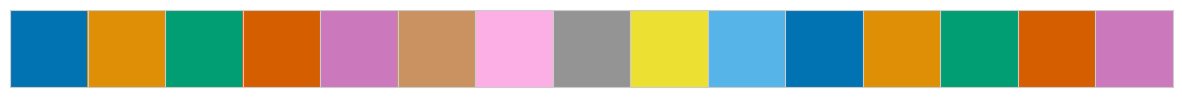

In [2]:
import sys
sys.path.insert(0, '..//src/')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import main
from common import enums, functions, schema
import geopandas as gpd
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_palette(sns.color_palette("colorblind", 15))
plt.rcParams['font.family'] = 'Times New Roman'
font_size = 12
params = {'axes.labelsize': font_size+2,
          'axes.titlesize':font_size+4,
          'legend.fontsize': font_size,
          'xtick.labelsize': font_size,
          'ytick.labelsize': font_size,
          'font.size': font_size}
plt.rcParams.update(params)
sns.set_style("whitegrid")
fig_format = "pdf"
dpi = 300
figsize = (12, 3.5)
figsize_map = (16, 8)
markers = ['P', 'o', '^', 's', '*', 'v']
linewidth = 0.1
edgecolor = 'black'
sns.palplot(sns.color_palette())

## PV generation using PVlib

In [51]:
import pvlib
from dataclasses import dataclass
from pvlib import location
from pvlib.pvsystem import PVSystem, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

geolocation = {"Birmingham": (52.489471,-1.898575),
"Cardiff": (51.481583,-3.179090),
"Edinburgh": (55.953251-3.188267),
"Glasgow": (55.860916,-4.251433),
"Leeds": (53.801277,-1.548567),
"Manchester" : (53.483959, -2.244644)}

@dataclass
class PVmodel:
  city_name: str
  irradiance_data: pd.DataFrame
  azimuth: int = 180
  slope:int = 30
  @property
  def location(self) -> pvlib.location.Location:
    if self.irradiance_data.index.tz is None:
      self.irradiance_data.index = self.irradiance_data.index.tz_localize(
          'Europe/London')
      print(self.irradiance_data.index.tz)
    return pvlib.location.Location(geolocation[self.city_name][0],
                                   geolocation[self.city_name][1],
                                   tz=self.irradiance_data.index.tz)

  def add_solar_components_to_ghi_data(self) -> pd.DataFrame:
    ghi_data = self.irradiance_data.copy()
    ghi_data.columns = ['ghi']
    # Calculate solar position for each timestamp in weather_data data
    solar_position: pd.DataFrame = self.location.get_solarposition(
        ghi_data.index)
    dni_data: pd.DataFrame = pvlib.irradiance.disc(
        ghi_data['ghi'].values,
        solar_zenith=solar_position['zenith'],
        datetime_or_doy=ghi_data.index)
    weather_data: pd.DataFrame = pd.concat([dni_data, ghi_data], axis=1)
    # weather_data = pd.concat([weather_data, temperature_data], axis=1)
    weather_data['dhi'] = (
        weather_data['ghi'] -
        np.cos(solar_position['zenith'] * np.pi / 180) * weather_data['dni']
    )  # GHI = DNI*cosθ + DHI
    return self.convert_to_poa(weather_data)

  def convert_to_poa(self, dataf: pd.DataFrame) -> pd.DataFrame:
    """Convert a dataframe with dni, ghi, dhi, apparent_zenith, azimuth and airmass_relative to poa"""

    # Calculate solar position for each timestamp in weather_data data
    solar_position = self.location.get_solarposition(dataf.index)

    # Calculate airmass for each timestamp in weather_data data
    airmass = self.location.get_airmass(dataf.index)

    # Calculate POA irradiance for each timestamp in weather_data data
    dataf = pvlib.irradiance.get_total_irradiance(
        surface_tilt=0,
        surface_azimuth=180,
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth'],
        dni=dataf['dni'],
        ghi=dataf['ghi'],
        dhi=dataf['dhi'],
        airmass=airmass['airmass_relative'])
    return dataf

  def get_pv_generation(self):

    temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm'][
        'open_rack_glass_glass']
    sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

    cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

    sandia_module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']

    cec_inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
    location = self.location

    system = PVSystem(
        surface_tilt=self.slope,
        surface_azimuth=self.azimuth,
        module_parameters=sandia_module,
        inverter_parameters=cec_inverter,
        temperature_model_parameters=temperature_model_parameters)

    mc = ModelChain(system, location)
    mc.run_model_from_poa(self.add_solar_components_to_ghi_data())
    kWp_pv = (sandia_module.Impo * sandia_module.Vmpo) / 1000
    return mc.results.ac / 1000 / kWp_pv  #kWh/kWp

## PVlib data UKPN network

In [55]:
city = "Birmingham"
column_names = [
  'Year', 'Month', 'Day', 'Hour', 'PWC', 'Cloud', 'DBT', 'WBT', 'RH', 'Press', 'WD', 'WS', 'GSR', 'DSR', 'Alt', 'Dec', 'Cloud1', 'DBT1', 'WBT1', 'Press1', 'WD1', 'WS1'
]
pathlist = Path(main.PATH_CIBSE_DATA).rglob('*_DSY2_2050High50*.csv')

dict_cibse_temperature: dict[str, pd.Series] = {}
for path in pathlist:
  print(path.stem)
  if city in path.stem:
    la_str = path.stem.split('_DSY2_2050High50')[0]
    temp_dataf = pd.read_csv(path,
                             skiprows=32,
                             header=None,
                             delimiter=",",
                             names=column_names)
    weather_data = functions.format_weather_data(temp_dataf)

power_output_data = []

for azimuth in (180+45, 180, 180-45):
  pv_model = PVmodel(
      city, weather_data[schema.DataSchema.SOLARRADIATION].to_frame(), azimuth=azimuth)
  pv_generation = pv_model.get_pv_generation()
  dataf = pv_generation.to_frame()
  new_name_col = f'P_{azimuth}_(kW)'
  dataf.columns = [new_name_col]
  power_output_data.append(dataf[new_name_col])

pv_outputs_df = pd.concat(power_output_data, axis=1)
pv_outputs_df['P_mean'] = pv_outputs_df.mean(axis=1)
pv_outputs_df.head()

Belfast_DSY2_2050High50_
Birmingham_DSY2_2050High50_
Cardiff_DSY2_2050High50_
Edinburgh_DSY2_2050High50_
Glasgow_DSY2_2050High50_
Leeds_DSY2_2050High50_
London_GTW_DSY2_2050High50
London_LHR_DSY2_2050High50
London_LWC_DSY2_2050High50
Manchester_DSY2_2050High50_
Europe/London
Europe/London
Europe/London


,P_225_(kW),P_180_(kW),P_135_(kW),P_mean
index,,,,
2050-05-01 00:00:00+00:00,-0.000341,-0.000341,-0.000341,-0.000341
2050-05-01 01:00:00+00:00,-0.000341,-0.000341,-0.000341,-0.000341
2050-05-01 02:00:00+00:00,-0.000341,-0.000341,-0.000341,-0.000341
2050-05-01 03:00:00+00:00,-0.000341,-0.000341,-0.000341,-0.000341
2050-05-01 04:00:00+00:00,-0.000341,-0.000341,-0.000341,-0.000341


In [106]:
pv_outputs_df.sum()

P_225_(kW)    571.102047
P_180_(kW)    564.719598
P_135_(kW)    531.973576
P_mean        555.931740
dtype: float64

Text(0.5, 0, '')

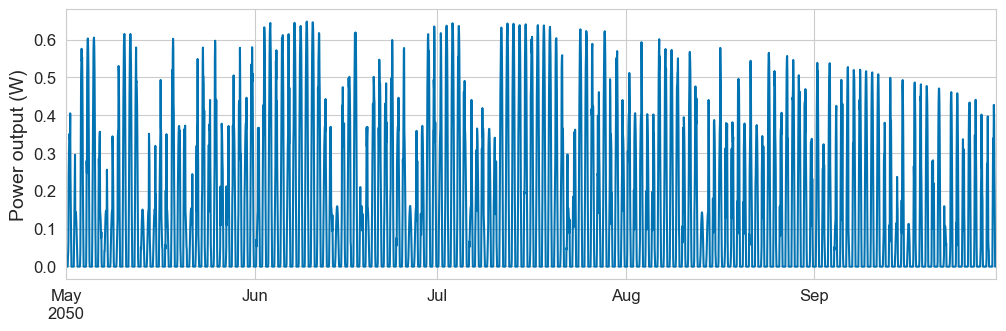

In [56]:
fig, ax = plt.subplots(figsize=figsize)
pv_outputs_df['P_mean'].plot(ax=ax)
ax.set_ylabel('Power output (W)')
ax.set_xlabel('')

### UKPN DFES DATA AT LSOA LEVEL FOR 2050

In [58]:
ukpn_dfes_path = Path(
    r"C:\Users\sceac10\OneDrive - Cardiff University\General\data\Electricity substation data\ukpn"
)
fn = "DFES-2022--Leading_the_Way--Domestic-PV-capacity--LSOA.csv"
dfes_dataf = pd.read_csv(ukpn_dfes_path / fn, index_col=0)
dfes_dataf.head()

,LSOAs,2021 (kW),2022 (kW),2023 (kW),2024 (kW),2025 (kW),2026 (kW),2027 (kW),2028 (kW),2029 (kW),...,2041 (kW),2042 (kW),2043 (kW),2044 (kW),2045 (kW),2046 (kW),2047 (kW),2048 (kW),2049 (kW),2050 (kW)
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01000001,City of London 001A,0,0,0,0,0,0,0,0,0,...,2,2,2,3,3,3,3,3,4,4
E01000002,City of London 001B,22,26,28,31,34,34,34,35,35,...,42,43,44,45,45,46,47,48,48,49
E01000003,City of London 001C,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
E01000005,City of London 001E,3,4,4,4,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
E01000006,Barking and Dagenham 016A,12,14,15,17,18,20,21,23,25,...,57,60,64,68,71,75,79,82,85,87


In [59]:
list_lsoas = dfes_dataf.index.unique()
len(list_lsoas)

10639

## Extract cooling demand of LSOAs in ukpn

In [61]:
residential_data = main.import_thermal_characteristics_data(
    main.PATH_GB_DATA / 'Thermal_characteristics_afterEE.csv', 2020, 2050)
filt = residential_data['LSOA_code'].isin(list_lsoas)
residential_data = residential_data[filt]
residential_data = residential_data.reset_index()
list_la_code = list(residential_data['ladcd'].unique())
residential_data.head()

,Index,LSOA_code,Local Authority,Region,Dwelling forms,Heating systems,Average thermal capacity kJ/K,Average thermal losses kW/K,Number of dwellings,Average annual heat demand kWh,Average floor area m2,Thermal capacity level,Outdoor air design temperature degreeC,CIBSE_city,ladcd,ladnm
0,62870,E01000001,City of London,London,flat,oil boiler,20699.495206,0.190661,14,8115.289346,82.797981,medium,-2,Birmingham,E09000001,city of london
1,62871,E01000001,City of London,London,semi-detached,gas boiler,24487.644025,0.262593,2,11176.994057,97.950576,medium,-2,Birmingham,E09000001,city of london
2,62872,E01000001,City of London,London,terraced,gas boiler,46503.543701,0.467660,1,19905.482816,186.014175,medium,-2,Birmingham,E09000001,city of london
3,62873,E01000001,City of London,London,terraced,resistance heating,16315.000000,0.062456,11,2658.375704,65.260000,medium,-2,Birmingham,E09000001,city of london
4,62874,E01000001,City of London,London,flat,gas boiler,14463.409091,0.114664,107,4880.555556,57.853636,medium,-2,Birmingham,E09000001,city of london


In [62]:
import icecream as ic

PATH_RESULTS = Path(
    r'C:\Users\sceac10\OneDrive - Cardiff University\General\04 - Analysis\2050 high emission')

# PATH_RESULTS = Path(r'C:/Users/sceac10/OneDrive - Cardiff University/General/04 - Analysis/2050 high emission/simulation/city of london_E09000001/')

pathlist = (Path(PATH_RESULTS)/'simulation').rglob('*_total_heating_outputs.csv')


lsoa_to_index_dict = dict(residential_data.groupby('LSOA_code')['Index'].apply(list))

frames:dict[str, pd.Series] = {}
for temp_path in pathlist:
  ic.ic(temp_path)
  la_str = temp_path.stem.split('_total_heating_outputs')[0]
  la_code = la_str.split('_')[-1]
  ic.ic(la_code)
  if la_code in list_la_code:
    temp_sim_results = pd.read_csv(temp_path, index_col=0, parse_dates=True)
    temp_sim_results.columns = [int(x) for x in temp_sim_results.columns]
    for lsoa_code, list_index in lsoa_to_index_dict.items():
      list_index_in_file = [
          x for x in temp_sim_results.columns if x in list_index
      ]
      if len(list_index_in_file) > 0:
        ic.ic(lsoa_code)
        frames[lsoa_code] = -temp_sim_results[list_index].sum(axis=1)

ukpn_lsoa_cooling_demand = pd.concat(frames, axis=1)
ukpn_lsoa_cooling_demand.to_csv(ukpn_dfes_path/"ukpn_lsoa_cooling_demand.csv")

ic| temp_path: WindowsPath('C:/Users/sceac10/OneDrive - Cardiff University/General/04 - Analysis/2050 high emission/simulation/aberdeen city_S12000033/aberdeen city_S12000033_total_heating_outputs.csv')
ic| la_code: 'S12000033'
ic| temp_path: WindowsPath('C:/Users/sceac10/OneDrive - Cardiff University/General/04 - Analysis/2050 high emission/simulation/aberdeenshire_S12000034/aberdeenshire_S12000034_total_heating_outputs.csv')
ic| la_code: 'S12000034'
ic| temp_path: WindowsPath('C:/Users/sceac10/OneDrive - Cardiff University/General/04 - Analysis/2050 high emission/simulation/adur_E07000223/adur_E07000223_total_heating_outputs.csv')
ic| la_code: 'E07000223'
ic| lsoa_code: 'E01031338'
ic| lsoa_code: 'E01031339'
ic| lsoa_code: 'E01031340'
ic| lsoa_code: 'E01031341'
ic| lsoa_code: 'E01031342'
ic| lsoa_code: 'E01031343'
ic| lsoa_code: 'E01031344'
ic| lsoa_code: 'E01031345'
ic| lsoa_code: 'E01031346'
ic| lsoa_code: 'E01031347'
ic| lsoa_code: 'E01031348'
ic| lsoa_code: 'E01031349'
ic| lsoa_c

In [83]:
pv_outputs_df.index = ukpn_lsoa_cooling_demand.index

In [75]:
target_year = 2050
filt = dfes_dataf.index.isin(ukpn_lsoa_cooling_demand.columns)
total_capacity_installed = dfes_dataf.loc[filt, f'{target_year} (kW)'].sum()
total_pv_generation = pv_outputs_df[
    'P_mean'] * total_capacity_installed / 1000000 # from kWh to GWh
total_pv_generation = total_pv_generation.to_frame()
total_pv_generation.columns = ['PV_output']

In [76]:
total_pv_generation.sum()

PV_output    1892.357733
dtype: float64

## UKPN results for the entire area

In [77]:
scop=14/3.412 #https://www.eia.gov/todayinenergy/detail.php?id=40232
cop = scop*0.875
total_cooling_demand = ukpn_lsoa_cooling_demand.sum(
    axis=1).to_frame() / 1000000 / cop  # in GWh

total_cooling_demand.columns = ['Electricity_for_cooling_demand']
total_data = pd.concat([total_pv_generation, total_cooling_demand], axis=1)
total_data.head()

,PV_output,Electricity_for_cooling_demand
Time_(h),,
2050-05-01 00:00:00,-0.001162,0.0
2050-05-01 01:00:00,-0.001162,0.0
2050-05-01 02:00:00,-0.001162,0.0
2050-05-01 03:00:00,-0.001162,0.0
2050-05-01 04:00:00,-0.001162,0.0


In [78]:
normalised_data = total_data/total_data.max()
total_data.sum()

PV_output                         1892.357733
Electricity_for_cooling_demand    3664.764070
dtype: float64

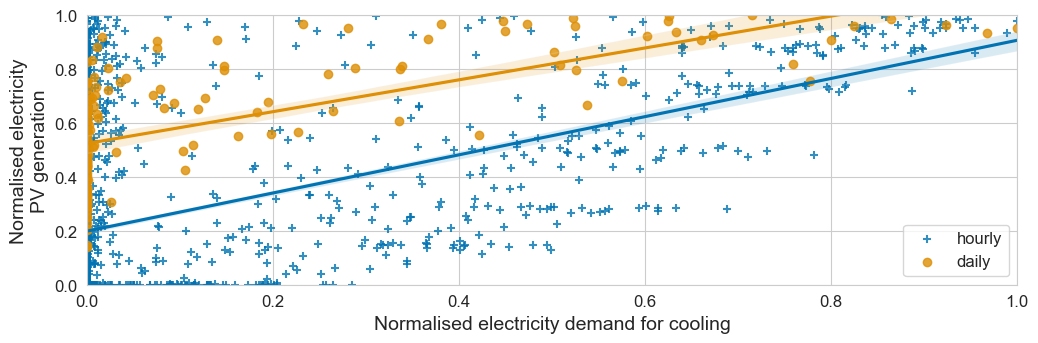

In [165]:
fig, ax = plt.subplots(figsize=figsize)
sns.regplot(data=normalised_data, x='Electricity_for_cooling_demand', y="PV_output", ax=ax, label="hourly", marker='+')
daily_data = normalised_data.resample('1d').mean()
# ax.scatter(x=daily_data['Electricity_for_cooling_demand'],
#            y=daily_data["PV_output"])
sns.regplot(data=daily_data/daily_data.max(), x='Electricity_for_cooling_demand', y="PV_output", ax=ax, label="daily")
ax.set_xlabel("Normalised electricity demand for cooling")
ax.set_ylabel("Normalised electricity\nPV generation")
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax.legend()

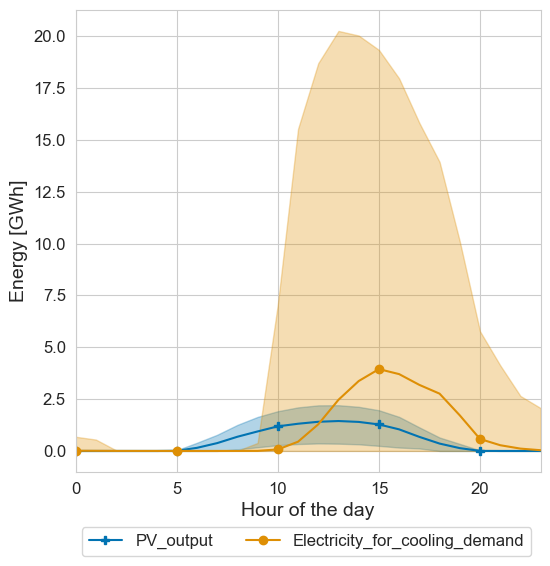

In [80]:
fig, ax = plt.subplots(figsize=(6,6))
average_week_day = total_data.groupby([total_data.index.hour]).mean().reset_index(drop=True)
max_week_day = total_data.groupby([total_data.index.hour]).max().reset_index(drop=True)
min_week_day = total_data.groupby([total_data.index.hour]).min().reset_index(drop=True)

for ii, c in enumerate(average_week_day.columns):
  average_week_day[c].plot(
        ax=ax,
        kind='line',
        marker=markers[ii],    markevery=5)
  ax.fill_between(average_week_day.index, min_week_day[c],max_week_day[c], color = sns.color_palette()[ii], alpha=0.3)
  
ax.set_ylabel('Energy [GWh]')
ax.set_xlabel('Hour of the day')
ax.margins(0, None)
ax.legend(bbox_to_anchor=(0.98, -0.12), ncol=4, borderaxespad=0.)

In [84]:
total_data['Net_electricity_for_cooling_demand'] = total_data['Electricity_for_cooling_demand'] - total_data['PV_output']
average_week_day = total_data.groupby([total_data.index.hour]).mean().reset_index(drop=True)
average_week_day.max()

PV_output                             1.441214
Electricity_for_cooling_demand        3.944412
Net_electricity_for_cooling_demand    2.667514
dtype: float64

In [120]:
(2.667514-3.944412)/3.944412

-0.32372328245629506

In [144]:
## Calculate the net-demand as the difference between the cooling demand and the pv generation
target_year = 2050
frames_net_demand = {}
for lsoa_code in ukpn_lsoa_cooling_demand.columns:
  pv_capacity_installed = dfes_dataf.loc[lsoa_code, f'{target_year} (kW)']
  ic.ic(lsoa_code, pv_capacity_installed)
  pv_generation = pv_outputs_df['P_mean'] * pv_capacity_installed
  frames_net_demand[lsoa_code] = (ukpn_lsoa_cooling_demand[lsoa_code]/cop -
                                  pv_generation)
net_demand_df = pd.concat(frames_net_demand, axis=1)

ic| lsoa_code: 'E01031338', pv_capacity_installed: 150
ic| lsoa_code: 'E01031339', pv_capacity_installed: 399
ic| lsoa_code: 'E01031340', pv_capacity_installed: 412
ic| lsoa_code: 'E01031341', pv_capacity_installed: 317
ic| lsoa_code: 'E01031342', pv_capacity_installed: 392
ic| lsoa_code: 'E01031343', pv_capacity_installed: 303
ic| lsoa_code: 'E01031344', pv_capacity_installed: 484
ic| lsoa_code: 'E01031345', pv_capacity_installed: 365
ic| lsoa_code: 'E01031346', pv_capacity_installed: 406
ic| lsoa_code: 'E01031347', pv_capacity_installed: 274
ic| lsoa_code: 'E01031348', pv_capacity_installed: 315
ic| lsoa_code: 'E01031349', pv_capacity_installed: 253
ic| lsoa_code: 'E01031350', pv_capacity_installed: 340
ic| lsoa_code: 'E01031351', pv_capacity_installed: 715
ic| lsoa_code: 'E01031352', pv_capacity_installed: 192
ic| lsoa_code: 'E01031353', pv_capacity_installed: 509
ic| lsoa_code: 'E01031354', pv_capacity_installed: 133
ic| lsoa_code: 'E01031355', pv_capacity_installed: 390
ic| lsoa_c

In [145]:
max_headroom = ukpn_lsoa_cooling_demand.max()/cop/1000
max_headroom = max_headroom.reset_index()
max_headroom.columns = ["LSOA", "Peak demand (GW)"]
max_headroom['Name'] = "Peak - Electricity for cooling demand"

q95_headroom = ukpn_lsoa_cooling_demand.quantile(0.95)/cop/1000
q95_headroom = q95_headroom.reset_index()
q95_headroom.columns = ["LSOA", "Peak demand (GW)"]
q95_headroom['Name'] = "95% percentiles - Electricity for cooling demand"
q95_headroom.head()

,LSOA,Peak demand (GW),Name
0,E01031338,0.646443,95% percentiles - Electricity for cooling demand
1,E01031339,0.577192,95% percentiles - Electricity for cooling demand
2,E01031340,0.897226,95% percentiles - Electricity for cooling demand
3,E01031341,0.664756,95% percentiles - Electricity for cooling demand
4,E01031342,0.940360,95% percentiles - Electricity for cooling demand


In [146]:
net_max_headroom = (net_demand_df.max()/1000).reset_index()
net_max_headroom.columns = ["LSOA", "Peak demand (GW)"]
net_max_headroom['Name'] = "Peak - Net electricity for cooling demand"

net_q95_headroom = (net_demand_df.quantile(0.95)/1000).reset_index()
net_q95_headroom.columns = ["LSOA", "Peak demand (GW)"]
net_q95_headroom['Name'] = "95% percentiles - Net electricity for cooling demand"

additional_headroom = pd.concat([max_headroom, q95_headroom, net_max_headroom, net_q95_headroom])

c:\Users\sceac10\OneDrive - Cardiff University\General\code\degree-days-analysis\degree_days\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\sceac10\OneDrive - Cardiff University\General\code\degree-days-analysis\degree_days\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\sceac10\OneDrive - Cardiff University\General\code\degree-days-analysis\degree_days\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, 'Additional headroom (GW)')

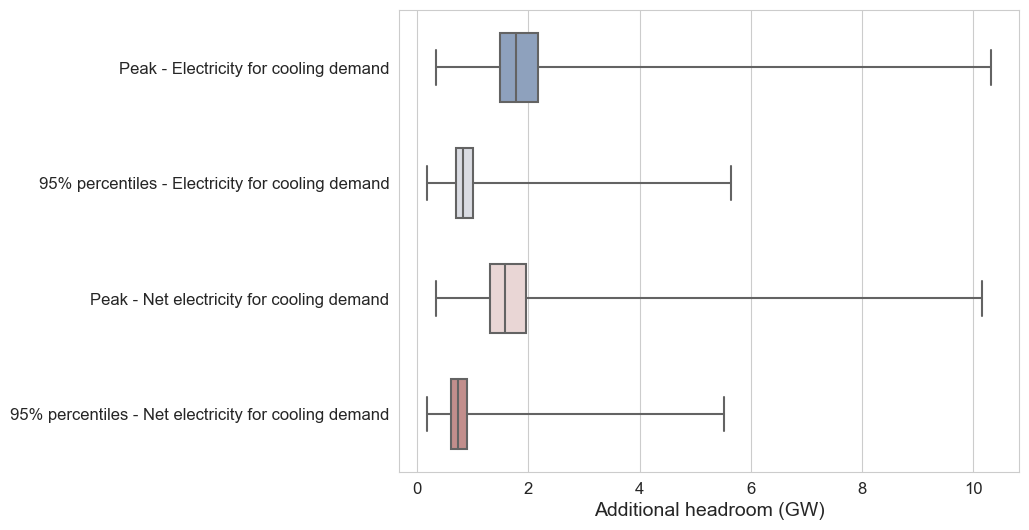

In [147]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(
    additional_headroom, x="Peak demand (GW)",  y='Name',
    whis=[0, 100], width=.6, palette="vlag"
)
ax.set_ylabel('')
ax.set_xlabel('Additional headroom (GW)')

In [148]:
pd.pivot_table(additional_headroom, values='Peak demand (GW)', columns='Name', index='LSOA').describe()

Name,95% percentiles - Electricity for cooling demand,95% percentiles - Net electricity for cooling demand,Peak - Electricity for cooling demand,Peak - Net electricity for cooling demand
count,10639.000000,10639.000000,10639.000000,10639.000000
mean,0.878188,0.784523,1.903425,1.700936
std,0.279755,0.262812,0.618970,0.578532
min,0.184705,0.183562,0.341182,0.336747
25%,0.693589,0.611211,1.498493,1.319496
50%,0.822456,0.731268,1.784885,1.587675
75%,0.998021,0.898144,2.175136,1.962463
max,5.634768,5.520071,10.314879,10.146361


In [152]:
0.731268/1.587675

0.4605904860881478

In [149]:
(1.587675-1.784885)/1.784885

-0.11048891105029181

In [151]:
0.822456/1.784885

0.46078935057440673

In [153]:
net_demand_df = net_demand_df.max().reset_index()
net_demand_df.columns = ["LSOA", "Peak demand (MW)"]
net_demand_df['Name'] = "Cooling demand\nminus PV generation"

c:\Users\sceac10\OneDrive - Cardiff University\General\code\degree-days-analysis\degree_days\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\sceac10\OneDrive - Cardiff University\General\code\degree-days-analysis\degree_days\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\sceac10\OneDrive - Cardiff University\General\code\degree-days-analysis\degree_days\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<AxesSubplot: xlabel='Name', ylabel='Peak demand (MW)'>

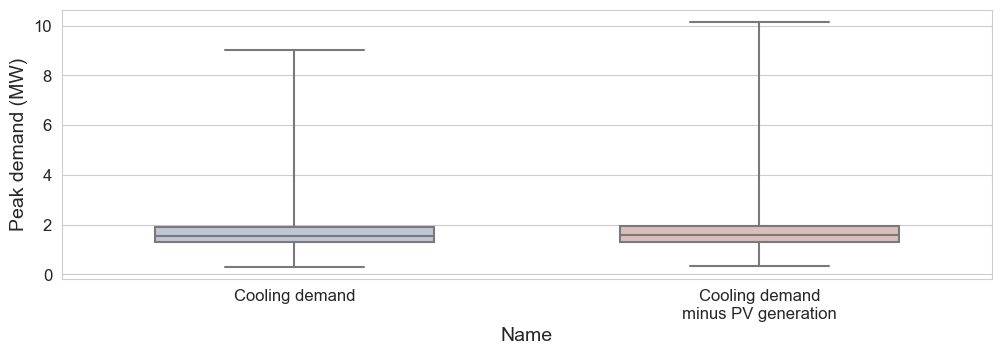

In [154]:
fig, ax = plt.subplots(figsize=figsize)
peak_demand = ukpn_lsoa_cooling_demand.max()/scop
peak_demand = peak_demand.reset_index()
peak_demand.columns = ["LSOA", "Peak demand (MW)"]
peak_demand['Name'] = "Cooling demand"
peak_demand = pd.concat([peak_demand, net_demand_df])
peak_demand["Peak demand (MW)"] = peak_demand["Peak demand (MW)"]/1000
# # Plot the orbital period with horizontal boxes
sns.boxplot(
    peak_demand, x='Name',  y="Peak demand (MW)",
    whis=[0, 100], width=.6, palette="vlag"
)

# # Add in points to show each observation
# sns.stripplot(planets, x="distance", y="method", size=4, color=".3")

In [ ]:
net_demand_df.head()

,LSOA,Peak demand (MW),Name
0,E01031338,1449.654299,Cooling demand\nminus PV generation
1,E01031339,1270.468373,Cooling demand\nminus PV generation
2,E01031340,2024.659497,Cooling demand\nminus PV generation
3,E01031341,1365.953223,Cooling demand\nminus PV generation
4,E01031342,1988.026214,Cooling demand\nminus PV generation


In [ ]:
lsoa_code

'E01032610'

In [ ]:
def plot_map(map_df,
             target,
             ax,
             vmin=None,
             vmax=None,
             cmap=None,
             legend=False, label_legend:str=''):

  # map_df = map_df.dropna(subset=[target])
  # create figure and axes for Matplotlib
  if vmin is None:
    if map_df[target].min() < 0:
      vmin = map_df[target].min()
    else:
      vmin = 0
  if vmax is None:
    vmax = map_df[target].max()

  if cmap == None:
    cmap = 'Blues'

  ax.axis('off')
  ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

  map_df = map_df.to_crs(epsg=3395)  # mercator projections

  if legend:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    map = map_df.plot(column=target,
                      cmap=cmap,
                      linewidth=0.01,
                      ax=ax,
                      edgecolor='black',
                      vmin=vmin,
                      vmax=vmax,
                      legend=legend,
                      legend_kwds={
                          "label": label_legend,
                          "orientation": "horizontal"
                      },
                      cax=cax)
  else:
    map = map_df.plot(column=target,
                      cmap=cmap,
                      linewidth=0.01,
                      ax=ax,
                      edgecolor='black',
                      vmin=vmin,
                      vmax=vmax)
  plt.close()
  return map


In [ ]:
path_map =  Path(r"C:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\00 - Final data\maps")
file = "UK_2011_Census_boundaries_LSOA_fixed.geojson"
path_map = path_map/file
map_df = gpd.read_file(path_map)
filt = map_df['GeographyCode'].isin(dfes_dataf.index)
map_df.head()

,OBJECTID,AREA_ID,AREA_NAME,MaxSimpTol,MinSimpTol,OBJECTID_1,GeographyCode,KS601EW0001,KS601EW0002,KS601EW0003,...,KS601EW0014,KS601EW0015,Full_time_PC,Part_time_PC,Unemployed_PC,Retired_PC,_errors,layer,path,geometry
0,1024,E01027993,Ashfield 012C,75,75.00,34840.0,E01027993,1158.0,197.0,409.0,...,2.0,17.0,35.319516,17.012090,3.626943,20.811744,Nested shells,Fixed geometries,MultiPolygon?crs=EPSG:4326&field=OBJECTID:inte...,"MULTIPOLYGON (((-1.30514 53.04483, -1.30785 53..."
1,48,E01020056,Mid Devon 008C,75,75.00,27061.0,E01020056,1517.0,201.0,488.0,...,3.0,9.0,32.168754,13.249835,2.241266,13.843111,Nested shells,Fixed geometries,MultiPolygon?crs=EPSG:4326&field=OBJECTID:inte...,"MULTIPOLYGON (((-3.41207 50.80506, -3.41064 50..."
2,271,E01024364,Maidstone 017A,75,18.75,31279.0,E01024364,1162.0,157.0,384.0,...,6.0,7.0,33.046472,13.511188,2.581756,19.018933,Nested shells,Fixed geometries,MultiPolygon?crs=EPSG:4326&field=OBJECTID:inte...,"MULTIPOLYGON (((0.63841 51.14202, 0.63435 51.1..."
3,636,E01018284,South Cambridgeshire 003C,75,75.00,25312.0,E01018284,932.0,160.0,417.0,...,1.0,5.0,44.742489,17.167382,1.609442,14.377682,Nested shells,Fixed geometries,MultiPolygon?crs=EPSG:4326&field=OBJECTID:inte...,"MULTIPOLYGON (((-0.00408 52.26949, -0.02667 52..."
4,3080,E01027595,Hambleton 010B,75,75.00,34445.0,E01027595,1158.0,182.0,414.0,...,4.0,6.0,35.751295,15.716753,2.072539,19.170984,Nested shells,Fixed geometries,MultiPolygon?crs=EPSG:4326&field=OBJECTID:inte...,"MULTIPOLYGON (((-1.18272 54.04060, -1.18525 54..."


#### PV capacity installed at LSOA level

In [ ]:
target_year = 2050
pv_installed_capacity_2050 = dfes_dataf.loc[:, f'{target_year} (kW)'].to_frame()
pv_installed_capacity_2050.columns = ["PV capacity installed (kW)"]
pv_installed_capacity_2050.head()

,PV capacity installed (kW)
LSOA11CD,
E01000001,4
E01000002,49
E01000003,1
E01000005,5
E01000006,87


In [ ]:
pv_installed_capacity_2050.sum()/1000000

PV capacity installed (kW)    3.403939
dtype: float64

In [ ]:
map_df = pd.merge(map_df, pv_installed_capacity_2050, left_on='GeographyCode', right_index=True)

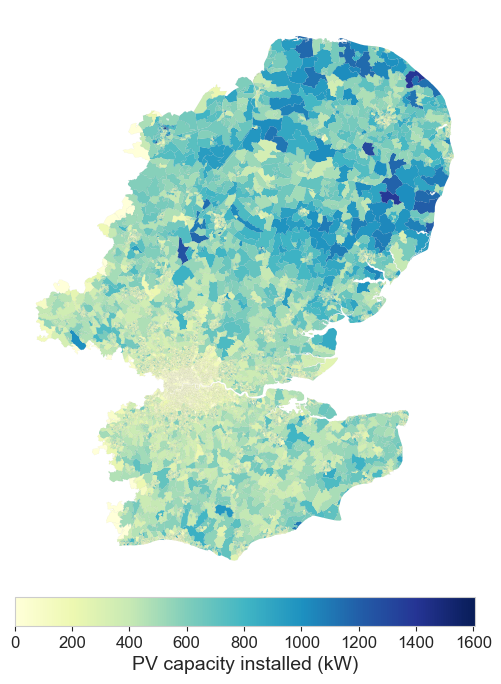

In [ ]:
fig, ax = plt.subplots(figsize=(figsize_map))
cmap_1 = "YlGnBu"
target = "PV capacity installed (kW)"
plot_map(map_df, target, ax, cmap=cmap_1, legend=True, label_legend="PV capacity installed (kW)")
# ax.set_title('Headroom demand in 2050 excl. cooling demand')
fig

#### Cooling demand at LSOA level

In [ ]:
cooling_demand = ukpn_lsoa_cooling_demand.sum().to_frame()/1000000/cop
cooling_demand.columns = ['Electricity for cooling (GWh)']

In [ ]:
filt = map_df['GeographyCode'].isin(cooling_demand.index)
map_df = map_df[filt]
map_df = pd.merge(map_df, cooling_demand, left_on='GeographyCode', right_index=True)

In [ ]:
cooling_demand.sum()

Electricity for cooling (GWh)    3664.76407
dtype: float64

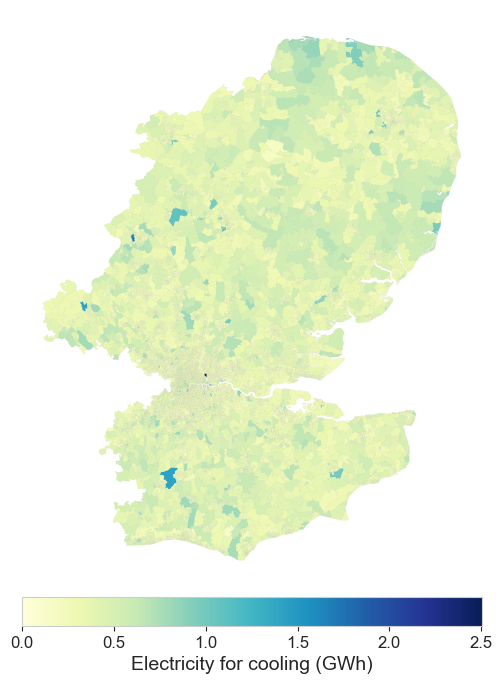

In [ ]:
fig, ax = plt.subplots(figsize=(figsize_map))
cmap_1 = "YlGnBu"
target = 'Electricity for cooling (GWh)'
plot_map(map_df, target, ax, cmap=cmap_1, legend=True, label_legend='Electricity for cooling (GWh)')
# ax.set_title('Headroom demand in 2050 excl. cooling demand')
fig